In [6]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
dataset = pd.read_csv('df_youtube.csv')
dataset

,sentiment,text
0,positive,Qahramonlarga ming rahmat Kun uz sizlarni otan...
1,positive,Қахрамон йигитларга шарафлар бўлсин доимо омад...
2,positive,Илохим олий укув юртларга укишга кириб кетсинл...
3,positive,Оллохни каромати чексиз!!! Оллохга шкур. Оллох...
4,positive,"Кизалок сог булсин, амин."
...,...,...
1047,negative,Bu jahannamda yongur itdan tarqagan lar Allo...
1048,negative,Нима биза куйми биза уриб улдириб узини дераза...
1049,negative,Халиям мактабларда чириб кеттган парта ...
1050,negative,Курисин йуколсин вадалари Билан


In [8]:
dataset['sentiment'].value_counts()

positive    550
negative    324
neutral     178
Name: sentiment, dtype: int64

In [44]:
indexes = dataset[dataset['sentiment']=='neutral'].index

In [46]:
dataset.drop(indexes, inplace=True)

In [47]:
dataset

,sentiment,text
177,negative,Туззиро совгаям бермабсилае . Нима туткизиб ку...
339,positive,Gap yoq omad ishlarga
854,negative,Терговда уриб у́лдирилган ...Бундай ишлар дим ...
117,positive,real life supermen lar ) Omad hammaga. Kimnidi...
830,positive,Siziyam ana burchakdagi qizniyam OLLOH omadlar...
...,...,...
646,positive,E malades Ukam.Senga havas qilamiz.
700,positive,Alloh siz va sizga o'hshagan jurnalistlarning ...
67,positive,Йигитлар молодцы.
891,negative,Далад ходимлари шуларни қилса қолганлардан ним...


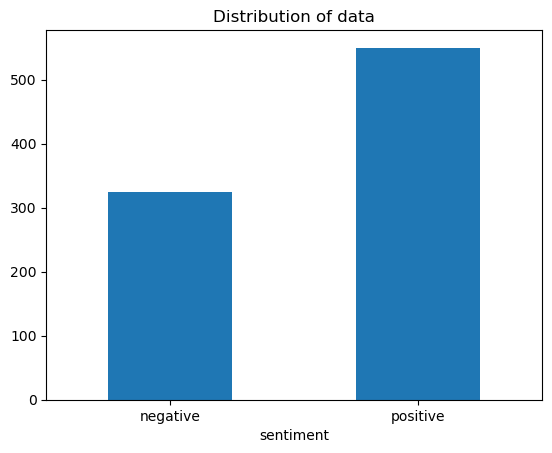

In [58]:
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['negative', 'positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

We shuffle dataframe values to work efficiently with our model

In [59]:
dataset = dataset.sample(frac=1)

In [60]:
dataset

,sentiment,text
270,positive,Жойлари жаннатда булсин
472,positive,Бобур.Акмалов.зур.шархловчи...Бобурни.видео.ро...
449,positive,Ўзбекистон давлатига ўзининг катта ҳиссасини қ...
94,positive,Аввало оллох.ота онасига минг рахмат шу болаларни
945,negative,Ishonmaymiz va'da qog'ozlarga qoladi
...,...,...
298,positive,Бундай инсонди бизга берган оллохга шукур
791,negative,Shu zolimlarni hammasiga qirgʻin kelsin!
103,positive,MashaAlloh Alloh bu yigitlarni sabab qilibdi.
720,negative,Навбатдаги сафсаталарини бошлаб юборибда. Муҳт...


In [61]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
stopwords = {
    "aftidan", "agar", "albatta", "allaqachon", "ammo", "aslida", "asosan", "asosiy", 
     "atrofida", "avvalgi", "axborot", "ayin", "aynan", "ayni", "ayniqsa", "ba'zi", "balki", 
     "barcha", "barchasi", "baribir", "ba’zi", "beradi", "beraman", "berdi", "bergan", "berilgan", 
     "berish", "besh", "beshinchi", "biladi", "bilaman", "bilan", "bir", "birga", "biri", "birinchi", 
     "biroq", "biroz", "bitta", "biz", "bizniki", "bizning", "bo'lgan", "bo'lish", "bo'lmoq", 
     "bog‘liq", "bor", "borish", "boshlamoq", "boshlanadi", "boshlaydi", "boshqa", "boxabar", 
     "bo‘l", "bo‘ladi", "bo‘lardi", "bo‘ldi", "bo‘lgan", "bo‘lib", "bo‘ling", "bo‘lish", 
     "bo‘lishi", "bo‘lishni", "bo‘lmadi", "bo‘lmagan", "bo‘lmaydi", "bo‘lmoq", "bo‘lsa", 
     "bo‘yicha", "bo‘ylab", "bu", "bular", "bundan", "bunday", "butun", "chetga", "chiqib", 
     "chiqqan", "chunki", "dahshatli", "dan", "darhol", "davom", "davomida", "deb", "degan", 
     "deya", "deyarli", "deydi", "deyiladi", "doim", "doir", "doirasida", "e'lon", "edi", "ega", 
     "ekan", "emas", "endi", "eng", "esa", "etadi", "etdi", "etgan", "etib", "etiladi", "etildi", 
     "etilgan", "etilishicha", "etish", "e’lon", "faqat", "foto", "gacha", "g‘alaba", "ham", "hamda", 
     "hamma", "hammasi", "haqda", "haqida", "haqidagi", "haqiqiy", "har", "harakat", "hatto", "hech", 
     "hisoblanadi", "hokazo", "holda", "hozir", "hozirda", "huzuridagi", "ichida", "ichiga", "ichiga ", 
     "ichkarida", "ikkalasi", "ikki", "ikkinchi", "iliq", "ishlab", "ishonaman", "istasangiz", "ixtiro", 
     "joriy", "joy", "joyda", "juda", "kabi", "keladi", "keldi", "kelgan", "kelib", "keling", "keng", 
     "kerak", "ketdi", "ketgan", "keyin", "keyingi", "kg", "kichik", "kim", "kimdir", "kimga", "km", 
     "ko'proq", "ko‘p", "ko‘plab", "ko‘proq", "ko‘ra", "ko‘rib", "ko‘rsatilgan", "ko‘rsatish", "lekin", 
     "lozim", "ma'lum", "ma'lumot", "mana", "marta", "masalan", "mavjud", "mayda", "mazkur", "ma’lum", 
     "ma’lumot", "men", "meni", "mening", "ming", "moddasi", "mos", "muhim", "mumkin", "muvofiq", "nafar", 
     "narsa", "natijada", "natijasida", "necha", "nega", "nima", "o'chirilgan", "o'sha", "o'zi", "o'zim", 
     "o'zimiz", "o'zingiz", "o'zlari", "oladi", "oldi", "oldin", "oldindan", "oldingi", "olgan", "olib", 
     "olingan", "olish", "oqibatida", "orasida", "orqada", "orqaga", "orqali", "ortiq", "ostida", "ozgina", 
     "o‘quv", "o‘rin", "o‘rniga", "o‘rtasida", "o‘sha", "o‘tdi", "o‘tgan", "o‘tkazish", "o‘z", "o‘zgarib", 
     "o‘zi", "o‘zim", "o‘zimiz", "o‘zingiz", "o‘zini", "o‘zining", "o‘zlari", "pastda", "pastga", "paydo", 
     "paytda", "qachon", "qadar", "qanday", "qaratilgan", "qarshi", "qayerda", "qaysi", "qayta", "qiladi", 
     "qilaman", "qilaylik", "qildi", "qildim", "qilgan", "qilib", "qilindi", "qilingan", "qilish", "qilmadim", 
     "qilmaydi", "qilmayman", "qilmoq", "qiluvchi", "qilyapti", "qismi", "qisqa", "qisqacha", "qo‘shilgan", 
     "quyida", "quyidagi", "ravishda", "sabab", "sabablar", "sababli", "sakkiz", "sakson", "salom", "sana", 
     "saqlamoq", "saqlanadi", "saqlash", "saqlaydi", "shaxsiy", "shu", "shunchaki", "shunday", "shunga", 
     "shuningdek", "sifatida", "siz", "sizniki", "sizning", "sodir", "so‘ng", "so‘nggi", "so‘rash", "ta", 
     "ta'qib", "ta'sir", "tahminan", "taklif", "taqdim", "tashqari", "tashqarida", "ta’minlash", "tez", 
     "tomonidan", "topilgan", "to‘g‘ri", "to‘g‘risida", "to‘g‘risidagi", "to‘rtta", "tufayli", "tugatish", 
     "turadi", "turli", "tuzatish", "u", "uch", "uchun", "ular", "ularni", "ularning", "unda", "unga", "uni", 
     "uning", "ushbu", "ustida", "uzoq", "va", "vaqt", "vaqtda", "vaqtida", "xabar", "xil", "xuddi", "xususan", 
     "ya'ni", "yakka", "yana", "yanada", "yangi", "yaqin", "yashirin", "yaxshi", "ya’ni", "yerda", "yetarli", 
     "yetib", "yirik", "yo'q", "yoki", "yonida", "yoqilgan", "yordam", "yo‘l", "yo‘q", "yuqorida", "yuqoriga", 
     "yuvildi", "yuz", "yuzasidan", "zarur", "zo‘rg‘a" 
}

In [62]:
def preprocess(textdata):
    processedtext = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedtext.append(tweetwords)
        
    return processedtext

In [63]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


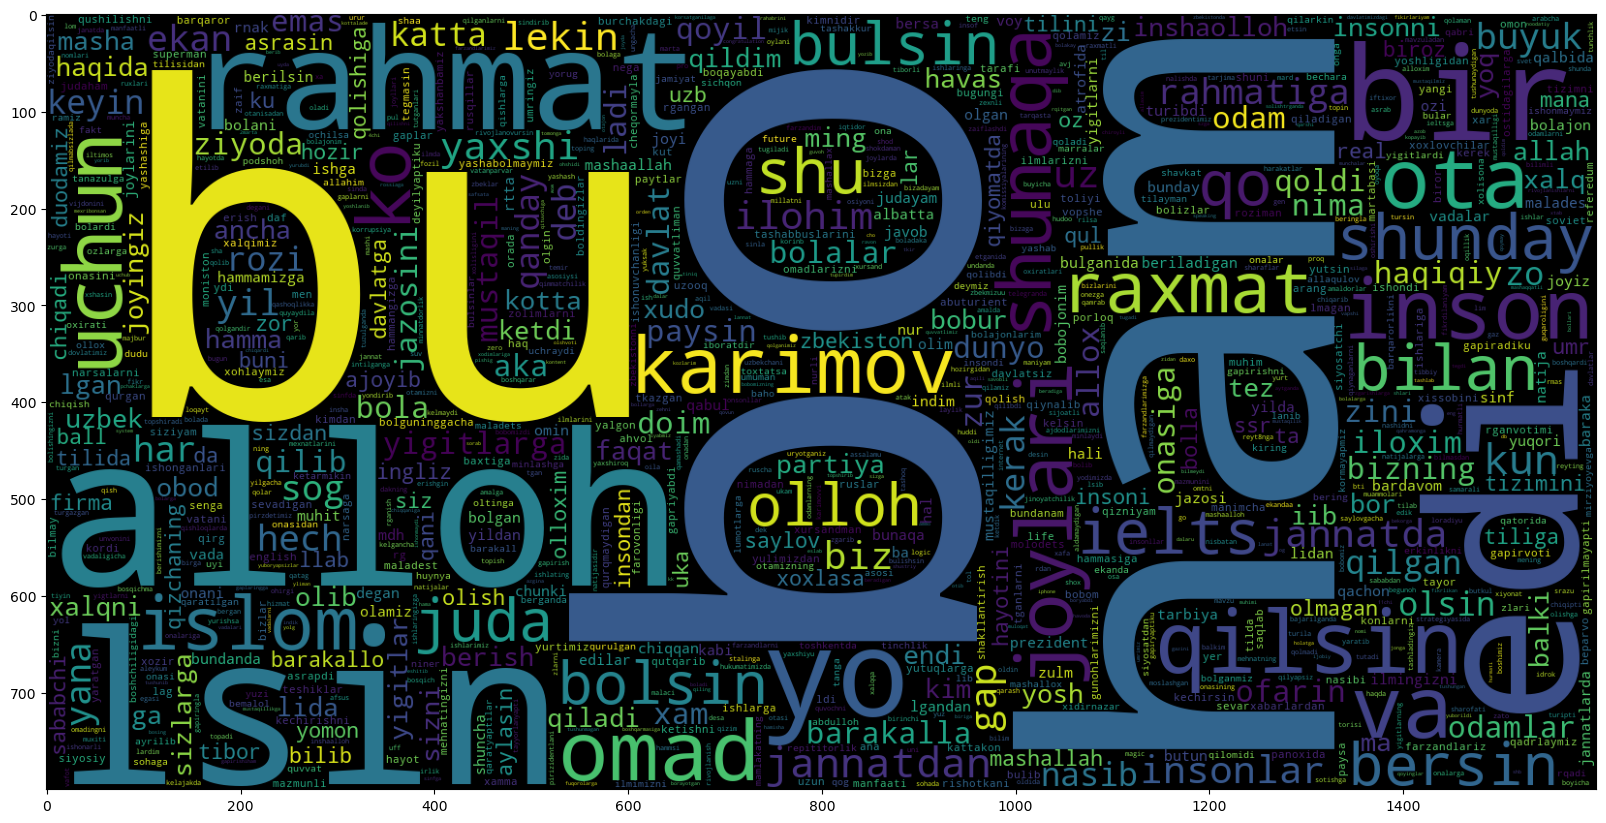

In [64]:
data_neg = processedtext[:500]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

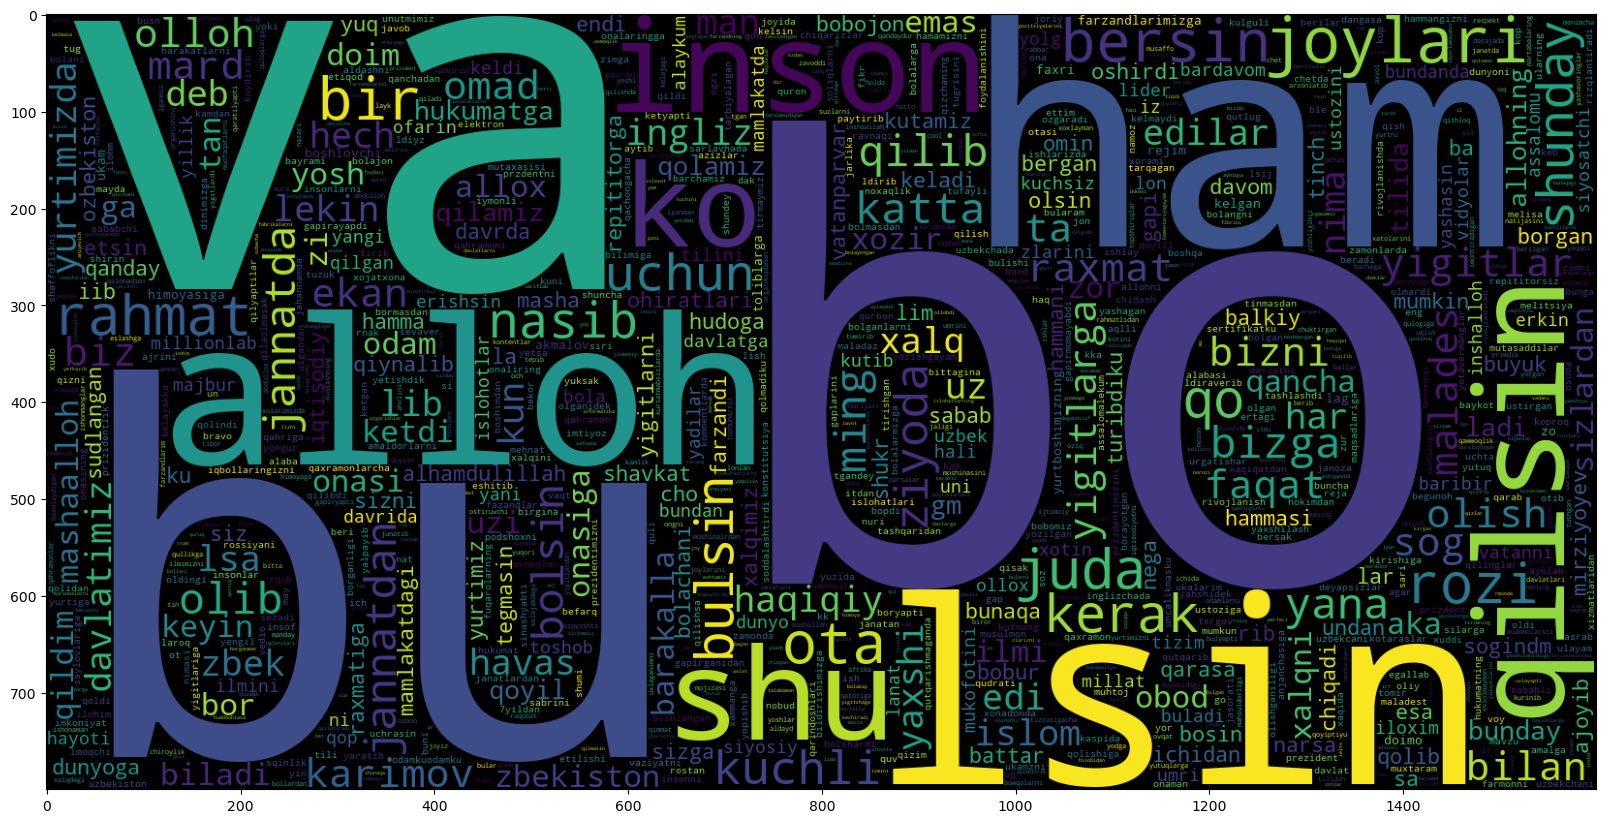

In [65]:
data_pos = processedtext[500:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [67]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  5243


In [68]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [69]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['negative', 'positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

/Users/asadbek/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asadbek/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/asadbek/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        24
    positive       0.45      1.00      0.62        20

    accuracy                           0.45        44
   macro avg       0.23      0.50      0.31        44
weighted avg       0.21      0.45      0.28        44



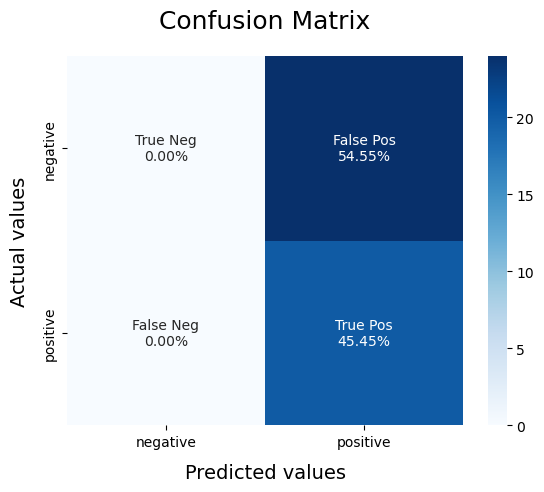

In [70]:
BNBmodel = BernoulliNB(alpha=3, fit_prior = True)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

    negative       1.00      0.25      0.40        24
    positive       0.53      1.00      0.69        20

    accuracy                           0.59        44
   macro avg       0.76      0.62      0.54        44
weighted avg       0.78      0.59      0.53        44



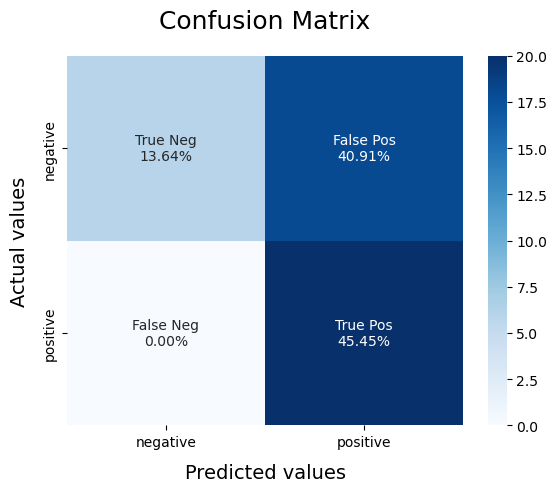

In [71]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    negative       1.00      0.12      0.22        24
    positive       0.49      1.00      0.66        20

    accuracy                           0.52        44
   macro avg       0.74      0.56      0.44        44
weighted avg       0.77      0.52      0.42        44



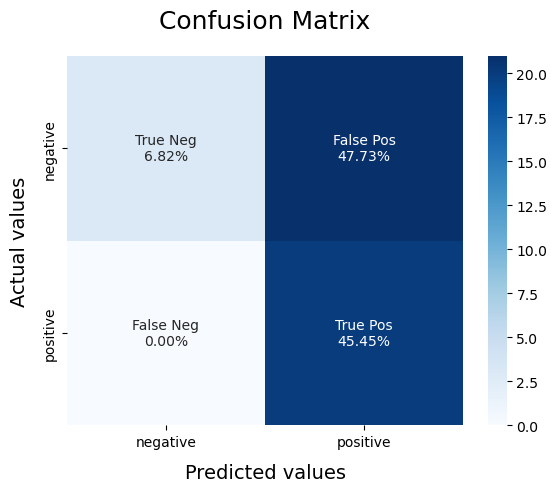

In [72]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [73]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [74]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["Islom Karimov oxirati obod bulsun",
            "Tushunmaymanda shunaqa odamlarni, nimadan norozi bo'lyotganini o'zi tushunmaydi, asil maqsadi nimaligini bilmaydi o'zi.",
            "Bizda qonun yoq"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                text sentiment
0                  Islom Karimov oxirati obod bulsun  positive
1  Tushunmaymanda shunaqa odamlarni, nimadan noro...  positive
2                                    Bizda qonun yoq  positive
